In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d


In [26]:
# Получаем даннные
data = pd.read_csv("./water.csv", parse_dates=["Дата"]).replace("-", np.NaN)
data["Температура воды"] = data["Температура воды"].astype(float)
data.head(5)


,Дата,Уровень воды,Изменение уровня воды,Температура воды
0,2023-04-01,264,47,NaN
1,2023-04-02,274,10,1.1
2,2023-04-03,260,-14,NaN
3,2023-04-04,257,-3,2.8
4,2023-04-05,278,21,3.0


<Axes: >

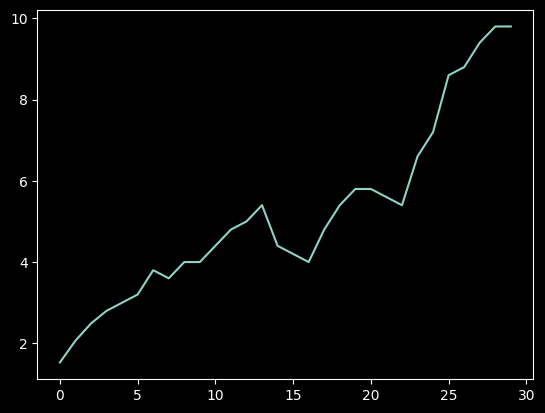

In [27]:
# Экстраполируем назад данные для температуры
extra = interp1d(
    data["Дата"][3:].astype("int64"),
    data["Температура воды"][3:],
    kind="quadratic",
    fill_value="extrapolate",
)
data.loc[:2, "Температура воды"] = extra(data[:3]["Дата"].astype("int64")).copy()
data["Температура воды"].plot()


In [28]:
# Создаем новый DataFrame с шагом в 1 час
new_index = pd.date_range(
    start=data["Дата"][0], end=data["Дата"][len(data) - 1], freq="H"
)
new_data = pd.DataFrame(
    {
        "Дата": new_index,
        "Уровень воды": None,
        "Изменение уровня воды": None,
        "Температура воды": None,
    }
)

mask = new_data["Дата"].apply(lambda x: x.hour == 0)
for col in new_data.columns[1:]:
    new_data.loc[mask, col] = data[col].copy()
new_data


,Дата,Уровень воды,Изменение уровня воды,Температура воды
0,2023-04-01 00:00:00,264.0,47.0,1.527886
1,2023-04-01 01:00:00,None,None,None
2,2023-04-01 02:00:00,None,None,None
3,2023-04-01 03:00:00,None,None,None
4,2023-04-01 04:00:00,None,None,None
...,...,...,...,...
692,2023-04-29 20:00:00,None,None,None
693,2023-04-29 21:00:00,None,None,None
694,2023-04-29 22:00:00,None,None,None
695,2023-04-29 23:00:00,None,None,None


<Axes: >

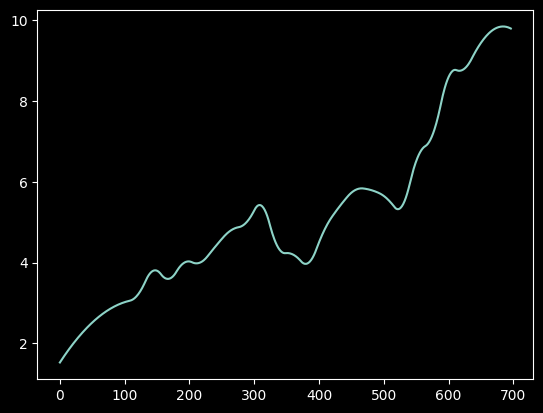

In [29]:
# Интерполируем данные температуры
interpolated = interp1d(
    data["Дата"].astype("int64"),
    data["Температура воды"],
    kind="quadratic",
    fill_value="extrapolate",
)

# Получаем интерполированные значения для нового DataFrame
interpolated_temperatures = interpolated(new_data["Дата"].astype("int64"))

# Создаем DataFrame с интерполированными данными
new_data["Температура воды"] = interpolated_temperatures
new_data["Температура воды"].plot()


<Axes: >

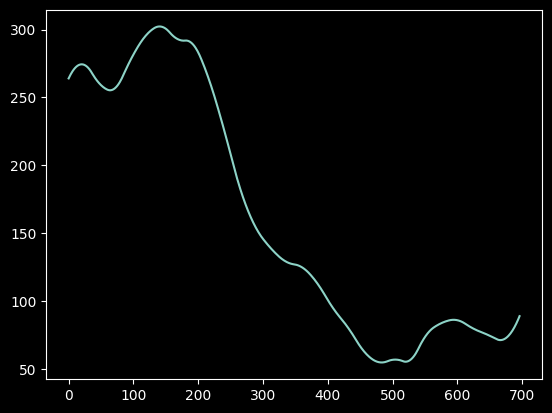

In [30]:
# Интерполируем данные уровня воды
interpolated = interp1d(
    data["Дата"].astype("int64"),
    data["Уровень воды"],
    kind="quadratic",
    fill_value="extrapolate",
)

# Получаем интерполированные значения для нового DataFrame
interpolated_temperatures = interpolated(new_data["Дата"].astype("int64"))

# Создаем DataFrame с интерполированными данными
new_data["Уровень воды"] = interpolated_temperatures
new_data["Уровень воды"].plot()


<Axes: xlabel='Температура воды'>

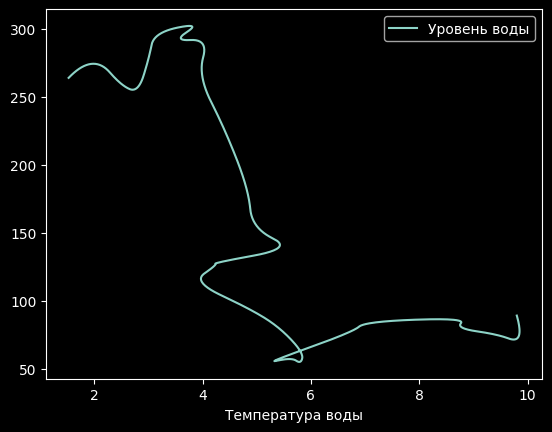

In [31]:
new_data.plot.line(x="Температура воды", y="Уровень воды")

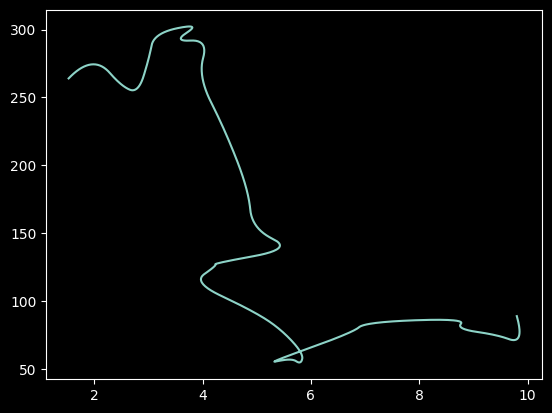

In [32]:
X, y = new_data[["Температура воды", "Уровень воды"]].values.T
plt.plot(X, y)


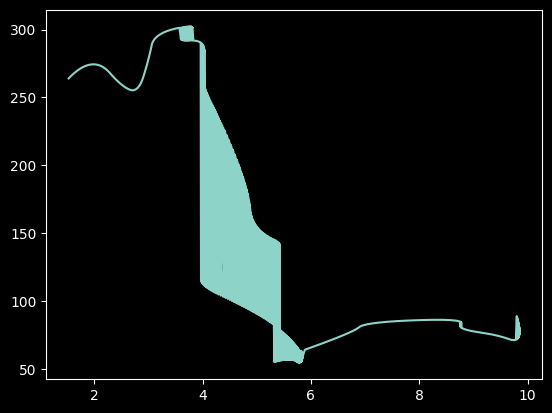

In [33]:
y = y[X.argsort()]
X = X[X.argsort()]
plt.plot(X, y)


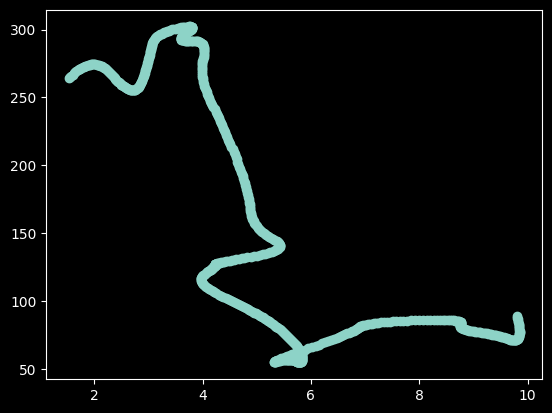

In [49]:
y = y[X.argsort()]
X = X[X.argsort()]
plt.scatter(X, y)


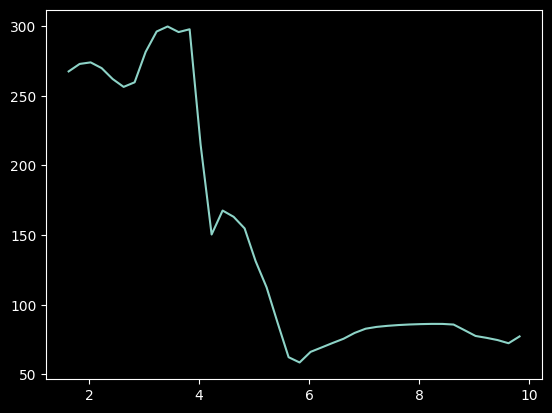

In [34]:
step = 0.2
X2 = []
y2 = []
for i in np.arange(min(X), max(X), step):
    X2.append(i + step / 2)
    y2.append(np.mean(y[(X >= i) & (X < i + step)]))

X2 = np.array(X2)
y2 = np.array(y2)

plt.plot(X2, y2)


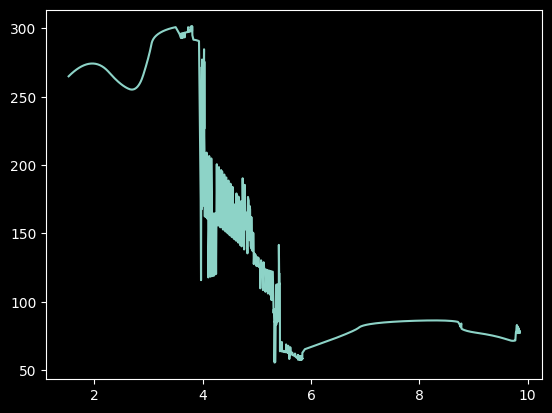

In [35]:
# Средняя кользящая по 3-м значениям
y2 = []
n = 3
for i in range(len(y)-n):
    y2.append(np.mean(y[i:i+n]))

plt.plot(X[:-n], y2)

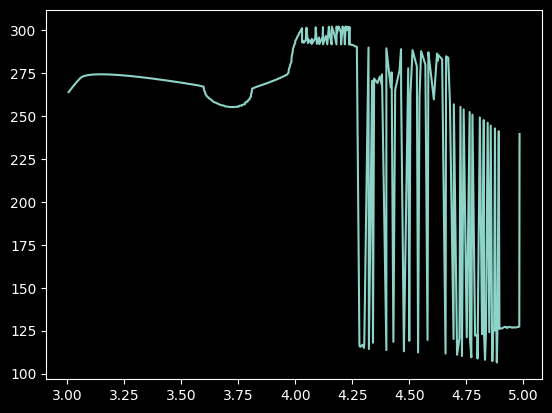

In [36]:
plt.plot(X[(X > 3) & (X < 5)], y[: sum((X > 3) & (X < 5))])

Удалять дубликаты бесполезно, потому что проблема не в них, а в неупорядоченном x, но и если его упорядочить, лучше не станет

<Axes: xlabel='Температура воды'>

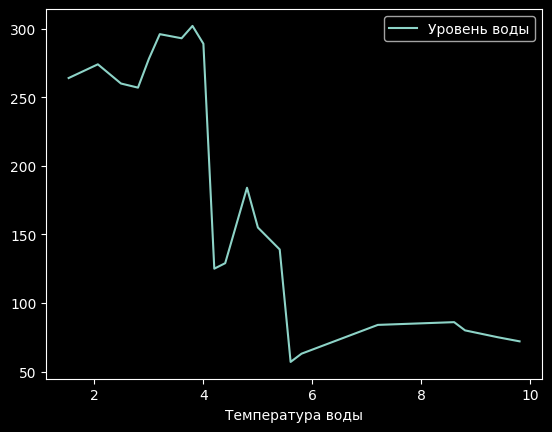

In [37]:
data.sort_values('Температура воды').drop_duplicates("Температура воды").plot.line(x="Температура воды", y="Уровень воды")

А если сделать это на итерполированных данны, то еще хуже

<Axes: xlabel='Температура воды'>

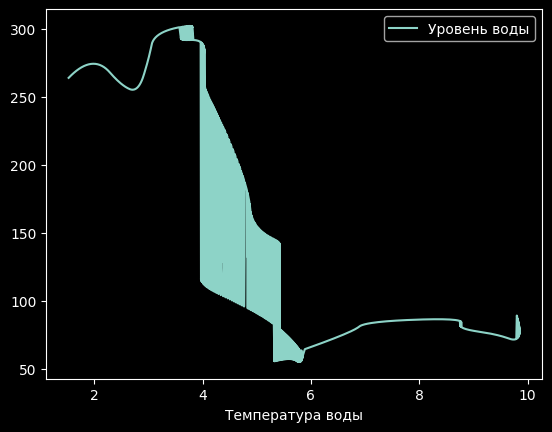

In [38]:
new_data.sort_values('Температура воды').drop_duplicates("Температура воды").plot.line(x="Температура воды", y="Уровень воды")

In [39]:
y_ = y[X.argsort()]
X_ = X[X.argsort()]

---
### Интерполяция

c:\Programs\Python\Python312\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


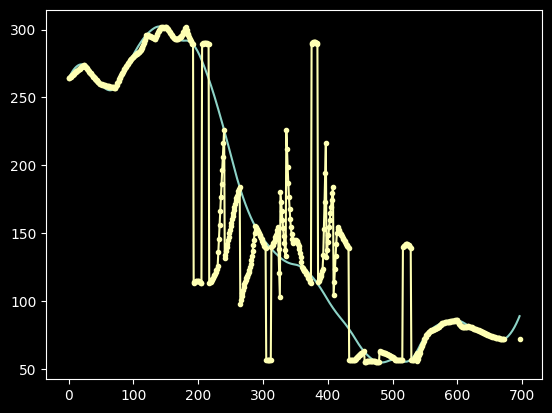

In [40]:
interpolated = interp1d(
    data["Температура воды"],
    data["Уровень воды"],
    kind="linear",
    fill_value="extrapolate",
)

# Получаем интерполированные значения для нового DataFrame
y_interp = interpolated(new_data["Температура воды"])

# Создаем DataFrame с интерполированными данными
new_data["Уровень воды"].plot()
plt.plot(y_interp, marker='.')


---
### Модель регрессии

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
X_train = data["Температура воды"].values[:, None]
y_train = data["Уровень воды"].values

X_test = new_data["Температура воды"].values[:, None]
y_test = new_data["Уровень воды"].values


In [43]:
def add_values(X, n=3):
    X = X.copy()
    X = np.hstack([X**i for i in range(n+1)])
    return X

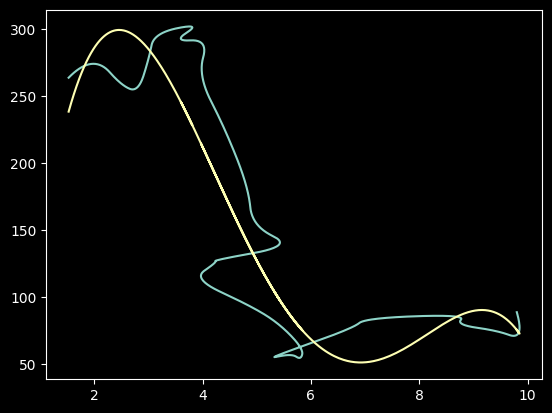

In [44]:
n = 4
model = LinearRegression().fit(add_values(X_train, n), y_train)
y_pred = model.predict(add_values(X_test, n))
plt.plot(X_test, y_test)
plt.plot(X_test, y_pred)


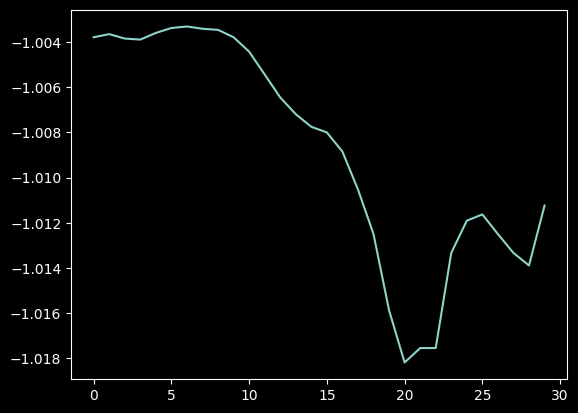

In [45]:
plt.plot(-1/y_train-1)

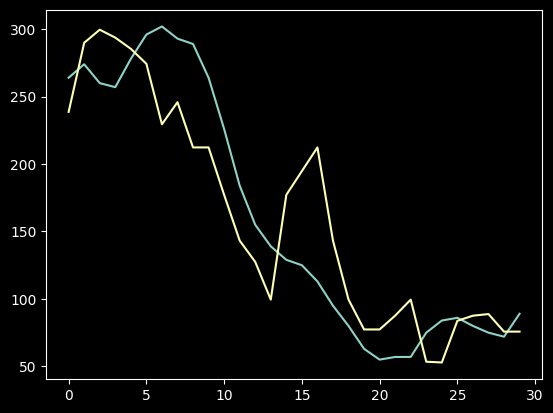

In [46]:
plt.plot(y_train)
plt.plot(model.predict(add_values(X_train, n)))


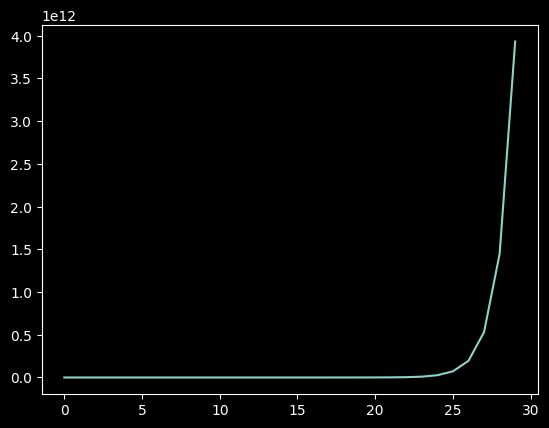

In [47]:
plt.plot(np.e ** (np.arange(30)))


In [48]:
alpha = max(y_train) - min(y_train)
y_t = np.log(-(y_train+1))
model = LinearRegression().fit(X_train, y_t)
y_pred = np.e**model.predict(X_test)*-1
plt.plot(X_test, y_test)
plt.plot(X_test, y_pred)


C:\Users\DaSh-More\AppData\Local\Temp\ipykernel_13476\2490482978.py:2: RuntimeWarning: invalid value encountered in log
  y_t = np.log(-(y_train+1))


ValueError: Input y contains NaN.

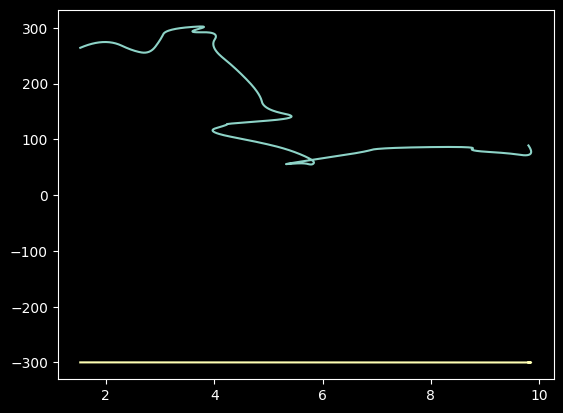

In [ ]:
# X_t = 1 / (1 + np.e**-X_train)
# model = LinearRegression().fit(X_t, y_train)

def predict(X):
    a = 300
    b = 0.2
    c = -7
    return (-a)/(1 + np.e**(-b*X+c))

y_pred = predict(X_test)
# y_pred = model.predict(1 / (1 + np.e**-X_test))
plt.plot(X_test, y_test)
plt.plot(X_test, y_pred)


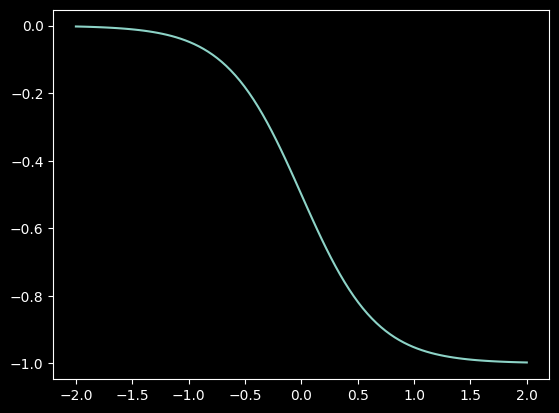

In [ ]:
X_ = np.linspace(-2, 2, 100)
y_ = - 1 / (1 + np.e**(-X_*3))
plt.plot(X_, y_)


---
### Объединение графиков

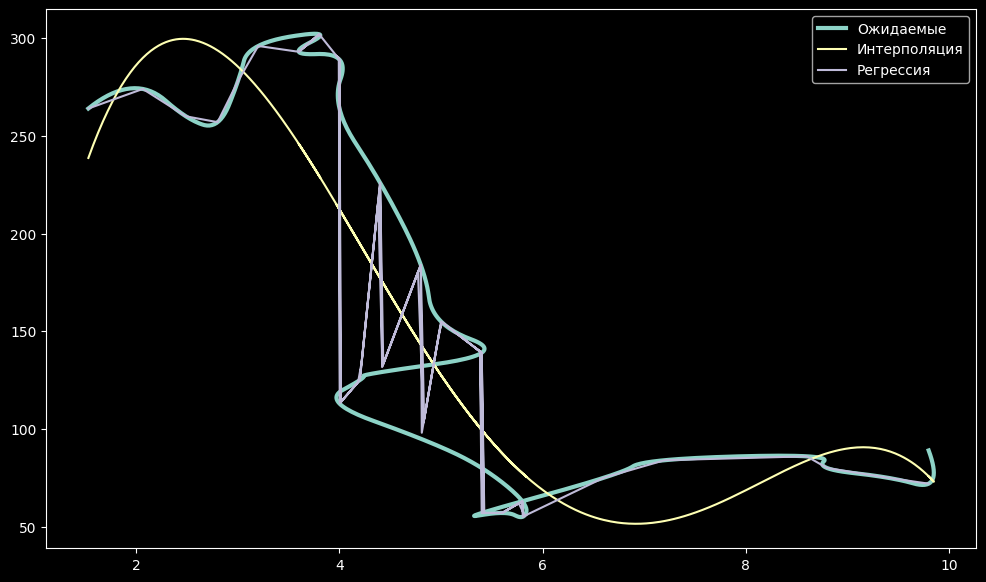

In [ ]:
plt.subplots(figsize=(12,7))
plt.plot(X_test, y_test, linewidth=3)
plt.plot(X_test, y_pred)
plt.plot(X_test, y_interp)
plt.legend(['Ожидаемые','Интерполяция','Регрессия'])


In [ ]:
# Средняя ошибка аппроксимации интерполяции
mas = (abs(y_test - y_interp) / y_test)
mas[mas!=np.inf].mean()*100

17.03745087205824

In [ ]:
# Средняя ошибка аппроксимации модели
mas = (abs(y_test - y_pred) / y_test)
mas[mas!=np.inf].mean()*100

26.20670844115788